In [1]:
import numpy as np
import json
import cvxpy as cp
from scipy import sparse as sp
import scipy.special as sps
import seaborn as sns
import matplotlib.pyplot as plt

from src.problems.utils import sample_data_for_group
from src.problems.problems import compute_producer_optimal_solution

(CVXPY) Apr 25 12:30:31 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.12.4544). Expected < 9.10.0. Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Apr 25 12:30:31 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.12.4544). Expected < 9.10.0. Please open a feature request on cvxpy to enable support for this version.')


In [2]:
# load data
with open("./data/amazon_predictions.npy", "rb") as f:
    REL_MATRIX = np.load(f)

with open("./data/amazon_user_groups.json", "r") as f:
    GROUPS_MAP = json.load(f)

In [ ]:
def compute_consumer_optimal_solution_cvar_relaxed_base(
    rel_matrix: np.ndarray,
    k_rec: int,
    producer_max_min_utility: float,
    gamma: float,
    group_assignments: list[int],
    alpha: float,
):
    # producer allocations
    allocations = cp.Variable(rel_matrix.shape, boolean=False)

    constraints = [
        # there should be k_rec producers allocated to consumer
        cp.sum(allocations, axis=1) == k_rec,
        # each producer should get at least gamma * optimal producer utility
        cp.sum(allocations, axis=0) >= gamma * producer_max_min_utility,
        allocations >= 0,
        allocations <= 1,
    ]

    # greedy producer allocations for consumer
    greedy_allocations = np.sort(rel_matrix, axis=1)[:, -k_rec:].sum(axis=1)

    # precomputing values for later processing
    unique_groups, group_indices = np.unique(group_assignments, return_inverse=True)
    num_groups = len(unique_groups)
    group_masks = [group_indices == i for i in range(num_groups)]
    group_sizes = np.array([mask.sum() for mask in group_masks])

    allocations = cp.sum(cp.multiply(rel_matrix, allocations), axis=1)
    # Compute normalized losses for all groups simultaneously (vectorized)
    normalized_losses = []
    for mask, size in zip(group_masks, group_sizes):
        group_alloc = allocations[mask]
        greedy_group_alloc = greedy_allocations[mask]

        # compute loss for each group
        normalized_loss = cp.sum(1 - (group_alloc / greedy_group_alloc)) / size
        normalized_losses.append(normalized_loss)

    # CVaR computation (vectorized)
    rho = cp.Variable(nonneg=True)
    cvar_objective = rho + (1 / ((1 - alpha) * num_groups)) * cp.sum(
        cp.pos(cp.hstack(normalized_losses) - rho)
    )

    # Define and solve the optimization problem
    problem = cp.Problem(cp.Minimize(cvar_objective), constraints)
    problem.solve(solver=cp.GUROBI, warm_start=True, **{"MIPGap": 1e-3})

    return problem.value, problem.variables()[1].value

def compute_consumer_optimal_solution_cvar_relaxed_topk_rounding(
    rel_matrix: np.ndarray,
    k_rec: int,
    producer_max_min_utility: float,
    gamma: float,
    group_assignments: list[int],
    alpha: float,
) -> tuple[float, np.ndarray]:
    problem_value, allocations = compute_consumer_optimal_solution_cvar_relaxed_base(
        rel_matrix,
        k_rec,
        producer_max_min_utility,
        gamma,
        group_assignments,
        alpha,
    )

    idxs = allocations.argsort(axis=1)[:, -k_rec:]
    alls = np.zeros_like(allocations)
    alls[np.arange(allocations.shape[0])[:, None], idxs] = 1
    return problem_value, alls





def compute_consumer_optimal_solution_cvar_relaxed_naive_rounding(
    rel_matrix: np.ndarray,
    k_rec: int,
    producer_max_min_utility: float,
    gamma: float,
    group_assignments: list[int],
    alpha: float,
) -> tuple[float, np.ndarray]:
    problem_value, allocations = compute_consumer_optimal_solution_cvar_relaxed_base(
        rel_matrix,
        k_rec,
        producer_max_min_utility,
        gamma,
        group_assignments,
        alpha,
    )
    return problem_value, np.round(allocations, 1).astype(int)

def compute_consumer_optimal_solution_cvar(
    rel_matrix: np.ndarray,
    k_rec: int,
    producer_max_min_utility: float,
    gamma: float,
    group_assignments: list[int],
    alpha: float,
) -> tuple[float, np.ndarray]:
    """
    Given a relevance matrix, this function returns the convex optimization problem
    that minimizes the Conditional Value at Risk (CVaR) of the groups of consumer utility given a fixed number
    of producers to recommend.

    The problem is solved using CVaR (Conditional Value at Risk) approach.
    The CVaR is defined as the average of the worst-case losses, where the worst-case losses are defined
    as the losses that exceed a certain threshold (1 - alpha).
    """
    # producer allocations
    C, P = rel_matrix.shape

    # 1) consumer‑greedy baseline
    greedy = np.sort(rel_matrix, axis=1)[:, -k_rec:].sum(axis=1)   # (C,)

    # 2) sparse group‐indicator G (shape G×C), with 1/|G_i| weights
    unique_groups, inv = np.unique(group_assignments, return_inverse=True)
    G = len(unique_groups)
    sizes = np.bincount(inv)
    data = 1.0 / sizes[inv]                                      # length C
    G_sparse = sp.csr_matrix((data, (inv, np.arange(C))), shape=(G, C))

    rel_c = cp.Constant(rel_matrix)
    Gc = cp.Constant(G_sparse)
    g_c = cp.Constant(greedy)

    x = cp.Variable((C, P), boolean=True)
    rho = cp.Variable(nonneg=True)
    t = cp.Variable(G, nonneg=True)

    u = cp.sum(cp.multiply(rel_c, x), axis=1)
    loss_c = 1 - u / g_c
    loss_g = Gc @ loss_c

    constraints = [
        cp.sum(x, axis=1) == k_rec,
        cp.sum(x, axis=0) >= gamma * producer_max_min_utility,
        t >= loss_g - rho,
    ]
    cvar_obj = rho + (1.0 / ((1 - alpha) * G)) * cp.sum(t)

    prob = cp.Problem(cp.Minimize(cvar_obj), constraints)
    prob.solve(solver=cp.GUROBI, warm_start=True, **{"MIPGap": 1e-3})

    return prob.value, x.value

In [4]:
N_CONSUMERS = 300
N_PRODUCERS = 300
GROUP_KEY = "top_category"
K_REC = 10
SOLVER = cp.GUROBI

In [5]:
rel_matrix_sampled, consumer_ids, group_assignments = sample_data_for_group(
    n_consumers=N_CONSUMERS,
    n_producers=N_PRODUCERS,
    groups_map=GROUPS_MAP,
    group_key=GROUP_KEY,
    data=REL_MATRIX,
    naive_sampling=True,
    seed=42,
)

producer_max_min_utility, _ = compute_producer_optimal_solution(
    rel_matrix=rel_matrix_sampled,
    k_rec=K_REC,
    solver=SOLVER,
)

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2653936
Academic license 2653936 - for non-commercial use only - registered to do___@student.uva.nl


In [6]:
solution, allocations = compute_consumer_optimal_solution_cvar_relaxed(
    rel_matrix=rel_matrix_sampled,
    k_rec=K_REC,
    producer_max_min_utility=producer_max_min_utility,
    gamma=0.5,
    group_assignments=group_assignments,
    alpha=0.95,
)

In [38]:
# save allocation into file
#with open("cvar_allocations.json", "w") as f:
    #json.dump(allocations.tolist(), f)

with open("cvar_allocations.json", "r") as f:
    cvar_allocations = json.load(f)
    cvar_allocations = np.array(cvar_allocations)

In [39]:
print(np.min(cvar_allocations.sum(axis=0)))
print(np.max(cvar_allocations.sum(axis=0)))

5.0
226.0


In [9]:
alls = np.round(allocations, 1).astype(int)

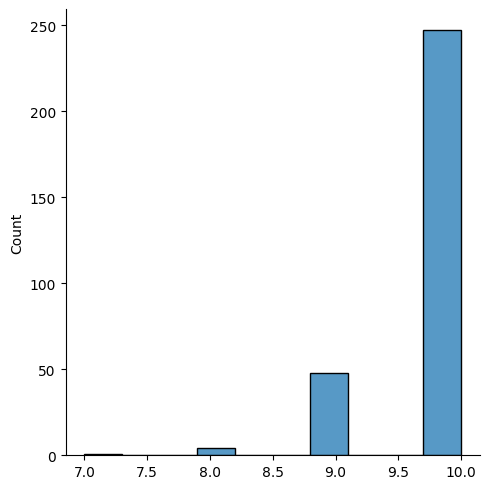

3 224


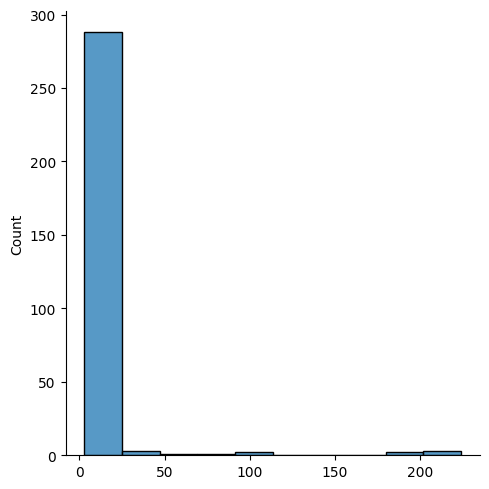

In [10]:
# distribution of allocations
sns.displot(alls.sum(axis=1), bins=10)
plt.show()
sns.displot(alls.sum(axis=0), bins=10)

print(np.min(alls.sum(axis=0)), np.max(alls.sum(axis=0)))

In [42]:
def top_k_rounding(allocations, k_rec):
    idxs = allocations.argsort(axis=1)[:, -k_rec:]
    alls = np.zeros_like(allocations)
    # set the top 10 allocations to 1
    alls[np.arange(allocations.shape[0])[:, None], idxs] = 1
    return alls

def naive_rounding(allocations):
    # naive rounding
    return np.round(allocations, 1).astype(int)


In [45]:
top_k_allocs = top_k_rounding(allocations, 10)
naive_allocs = naive_rounding(allocations)

print("Topk rounding pearson r =", np.corrcoef(top_k_allocs.flatten(), cvar_allocations.flatten())[0, 1])
print("Naive rounding pearson r =", np.corrcoef(naive_allocs.flatten(), cvar_allocations.flatten())[0, 1])

min_prod_util = 5
print("Percentage of producers with lower than min utility (topk rounding)", np.sum(top_k_allocs.sum(axis=0) < min_prod_util) / allocations.shape[1])
print("Percentage of producers with lower than min utility (naive rounding)", np.sum(naive_allocs.sum(axis=0) < min_prod_util) / allocations.shape[1])

Topk rounding pearson r = 0.951379310344828
Naive rounding pearson r = 0.9514856462813451
Percentage of producers with lower than min utility (topk rounding) 0.006666666666666667
Percentage of producers with lower than min utility (naive rounding) 0.15666666666666668
